<a href="https://colab.research.google.com/github/anupa-aa/ML-AI-Courswork-Module/blob/master/Anupa_Adikary_ex2_StochasticOptimisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Expectations:** run some stockastic optimisers to fit a linear model on the MNIST data set of hand written digits.


**Note we have swapped from using numpy to torch, the syntax is very similar!**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models,transforms
from torchvision.datasets import MNIST
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
# GENERATE MNIST DATASET - no need to edit
def mnist(batch_sz, valid_size=0.2, shuffle=True, random_seed=2000):
    num_classes = 10
    transform_train = transforms.Compose([
                        transforms.ToTensor(),
                    ])

    transform_valid = transforms.Compose([
                        transforms.ToTensor(),
                    ])

    transform_test = transforms.Compose([
                        transforms.ToTensor(),
                    ])

    # Training dataset
    train_data = MNIST(root='./datasets', train=True, download=True, transform=transform_train)
    valid_data = MNIST(root='./datasets', train=True, download=True, transform=transform_valid)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    if shuffle == True:
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_idx, valid_idx = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_sz, sampler=train_sampler,pin_memory=True)
    valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_sz, sampler=valid_sampler,pin_memory=True)

    # Test dataset
    test_data = MNIST(root='./datasets', train=False, download=True, transform=transform_test)
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_sz, shuffle=False, pin_memory=True)

    return train_loader, valid_loader, test_loader

In [ ]:
batch_size = 64 # this is batch size i.e. the number of rows in a batch of data, feel free try other values {32, 64, 128, 256, 512}

input_dimension = 1 * 28 * 28 # MNIST images are grey scale images 28 pixels wide and high
d = input_dimension # if you prefer a shorter varible name

number_of_classes = 10 # number of class of MNIST data set C = {0,1,2,3,4,5,6,7,8,9}

train_loader, valid_loader, test_loader=mnist(batch_size) # Create the data loaders these are objects that when looping over present batchs of data

# lists to store loss and accuracy values
sgd_train_losses, sgd_val_losses, sgd_train_acc, sgd_val_acc = [], [], [], []
opt_train_losses, opt_val_losses, opt_train_acc, opt_val_acc = [], [], [], []
adam_train_losses, adam_val_losses, adam_train_acc, adam_val_acc = [], [], [], []


In [ ]:
batch = next(iter(train_loader))
batch_content = batch[0]
print('dimension of single batch: ',batch_content.size())
print('code will convert 28*28 image in a single 784 vector of pixel values on which we will fit a linear model')

dimension of single batch:  torch.Size([64, 1, 28, 28])
code will convert 28*28 image in a single 784 vector of pixel values on which we will fit a linear model


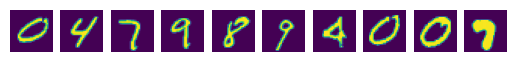

In [ ]:
# Visulise some training examples
k = 0
h = 10
f, axs = plt.subplots(1,h)

for k in range(h):
  img = batch_content[k,:,:,:].squeeze()
  axs[k].imshow(img)
  axs[k].axis("off")

**Loss Function** for mnist digits we will use the cross entropy loss:

\begin{align*}
\text{Cross Entropy Loss} : \frac{1}{N}\sum_{z=1}^N \ell_{z}(\mathbf{y}_{z},\mathbf{y}_z^*) = - \frac{1}{N}\sum_{z=1}^N\sum_{c \in C}y^*_{z,c} \text{log}(y_{z,c}) = - \frac{1}{N}\sum_{z=1}^N\mathbf{y}^*_{z,c} \text{log}(\text{softmax}(\mathbf{x}_z \mathbf{w}))
\end{align*}

where $y^*_z$ is $c_z^{th}$ unit vector corrisponding were $c_z$ is the class of the $z^{th}$ training example. For a concrete example is the class of the first example was 0, $y_0^* = [1,0,0,0,0,0,0,0,0,0]$.

\begin{align*}
\text{softmax}(\mathbf{x}) = \frac{\exp{\mathbf{x}}}{\sum_i \exp{x_i}}
\end{align*}

In [ ]:
# By default the data loader gives you the class value as a integer rather than a one hot vector as show above

def index_to_one_hot(y, classes=10):
  b = len(y) # batchsize
  one_hot = torch.zeros((b, classes), device=y.device)
  xs = torch.arange(b, device=y.device)
  one_hot[xs,y] = 1
  return one_hot

y = torch.randint(10,(10,))
print('y',y)
print('y',index_to_one_hot(y))

y tensor([7, 0, 9, 2, 4, 7, 3, 7, 4, 1])
y tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])


**Question 1** Complete the CE loss function below:

In [ ]:
# As before please complete the following two functions. Remember here X and y are batches of b examles.

def CE_loss(X, ystar, w):
  # ----------------------------
  N = X.shape[0]

  m = X@w

  loss = -torch.mean(ystar * torch.log(F.softmax(m,dim=1)))*10

  """
  softmax_probs = torch.softmax(m, dim=1)
  y_indices = torch.argmax(ystar, dim=1, keepdim=True)
  log_probs = torch.log(softmax_probs.gather(1, y_indices))

  loss = -torch.mean(log_probs)"""


  # ---------------------------
  return float(loss)

In [ ]:
Y = index_to_one_hot(y)
X = torch.randn(10,10)

print('your fucntion:',float(CE_loss(X,Y,torch.eye(10).float())))
print('should match this fucntion:',float(F.cross_entropy(X, y)))

your fucntion: 2.8927407264709473
should match this fucntion: 2.8927407264709473


**Question 2** (hard) Derive the gradeint of the CE loss. Write you awnser here in latex:
(Hint use the chain rule
$\frac{\partial \mathcal{L}}{\partial \mathbf{w}} = \frac{\partial \mathcal{L}}{\partial \mathbf{a}} \frac{\partial \mathbf{a}}{\partial \mathbf{w}}
$, try setting $\mathbf{a} = \text{softmax}(\mathbf{x}_z \mathbf{w})$):

\begin{equation}
  \nabla_\ell(\mathbf{w}) =
\end{equation}

**Question 3** complete the function to calcululat the gradeint of the CE loss below.


In [ ]:
def grad_func(X, ystar, w):
  n = X.size()[0]
  # your code here
  # ----------------------------

  grad = -1/n * X.T@(ystar - F.softmax(X@w, dim=1))


  # ----------------------------
  return grad

In [ ]:
# useful function to calculate accuracy

def accuracy(out, targets):
    _, pred = torch.max(out, 1)
    correct = torch.eq(pred, targets).sum()
    acc = torch.mean(torch.eq(pred, targets).float())
    return correct, float(100. * acc)

In [ ]:
def test(w, valid_loader): # function that evaluates loss on vaildation set
    total_loss, total_correct, total_num = 0, 0, 0
    for batch in valid_loader:
      X,y = batch[0].to(device).view(batch[0].size()[0],input_dimension), batch[1].to(device)
      Y = index_to_one_hot(y, classes=10)
      loss_train = CE_loss(X, Y, w)
      correct, acc = accuracy(X.mm(w), y)
      total_correct += correct
      total_loss += loss_train*X.size()[0]
      total_num += X.size()[0]
    return float(total_loss/total_num), float(total_correct/total_num * 100)

**Question 4** implement the SGD with momentum and experiement with with different batch sizes. What do you notice?

In [ ]:
with torch.no_grad(): # in this exersize we will not use autograd you will have calucated gradent

  # fixing a device to run the codes on
  device = torch.device("cuda:0")

  w = torch.zeros(input_dimension,number_of_classes).to(device)
  m = torch.zeros(input_dimension,number_of_classes).to(device)

  eta = 1e-1
  mu = 0.9
  num_epochs = 10

  for i in range(num_epochs):
    total_loss, total_correct, total_num = 0, 0, 0
    for batch in train_loader:
      #extractign data and labels from batch
      X,y = batch[0].to(device).view(batch[0].size()[0],input_dimension), batch[1].to(device)
      Y = index_to_one_hot(y, classes=10)
      # ----------------------------
      # Optimisation -  Your code here

      m = mu*m - eta*grad_func(X,Y,w)

      w = w + m


      # ----------------------------
      # track loss and accuracy after every step
      loss_train = CE_loss(X, Y, w)
      correct, acc = accuracy(X.mm(w), y)
      total_correct += correct
      total_loss += loss_train*X.size()[0]
      total_num += X.size()[0]

    # ----------------------------
    # After each epoch track metrics
    sgd_train_losses.append(float(total_loss/total_num))
    sgd_train_acc.append(float(total_correct/total_num * 100))
    val_loss, val_acc = test(w, valid_loader)
    sgd_val_losses.append(val_loss)
    sgd_val_acc.append(val_acc)
    print('train loss: {:.2e} | train acc: {:.2f} | eta: {:.2f}'.format(float(total_loss/total_num), float(total_correct/total_num * 100), eta))
    print('val loss: {:.2e} | val acc: {:.2f}'.format(val_loss, val_acc))
    print('-'*50)
    # ----------------------------
    # Adjust the learning rate
    eta *= 0.9

train loss: 3.58e-01 | train acc: 89.71 | eta: 0.10
val loss: 3.26e-01 | val acc: 90.46
--------------------------------------------------
train loss: 3.06e-01 | train acc: 91.47 | eta: 0.09
val loss: 3.63e-01 | val acc: 89.06
--------------------------------------------------
train loss: 2.90e-01 | train acc: 92.02 | eta: 0.08
val loss: 3.18e-01 | val acc: 90.93
--------------------------------------------------
train loss: 2.81e-01 | train acc: 92.22 | eta: 0.07
val loss: 3.17e-01 | val acc: 91.53
--------------------------------------------------
train loss: 2.77e-01 | train acc: 92.43 | eta: 0.07
val loss: 3.06e-01 | val acc: 91.24
--------------------------------------------------
train loss: 2.70e-01 | train acc: 92.58 | eta: 0.06
val loss: 3.09e-01 | val acc: 91.36
--------------------------------------------------
train loss: 2.66e-01 | train acc: 92.67 | eta: 0.05
val loss: 3.04e-01 | val acc: 91.27
--------------------------------------------------
train loss: 2.63e-01 | trai

Text(0, 0.5, 'val acc')

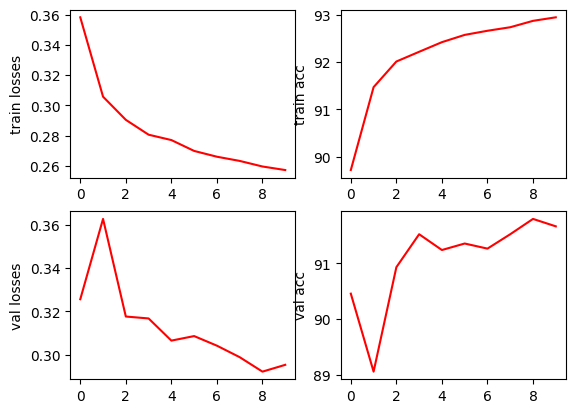

In [ ]:
# plot stuff - reuse this cell for plotting bonus material too.
f, axs = plt.subplots(2,2)
axs[0,0].plot(np.arange(len(sgd_train_losses)),sgd_train_losses, 'red')
axs[0,0].plot(np.arange(len(opt_train_losses)),opt_train_losses, 'blue')
axs[0,0].plot(np.arange(len(adam_train_losses)),adam_train_losses, 'black')
axs[0,0].set_ylabel('train losses')
axs[0,1].plot(np.arange(len(sgd_train_acc)),sgd_train_acc, 'red')
axs[0,1].plot(np.arange(len(opt_train_acc)),opt_train_acc, 'blue')
axs[0,1].plot(np.arange(len(adam_train_acc)),adam_train_acc, 'black')
axs[0,1].set_ylabel('train acc')
axs[1,0].plot(np.arange(len(sgd_val_losses)),sgd_val_losses, 'red')
axs[1,0].plot(np.arange(len(opt_val_losses)),opt_val_losses, 'blue')
axs[1,0].plot(np.arange(len(adam_val_losses)),adam_val_losses, 'black')
axs[1,0].set_ylabel('val losses')
axs[1,1].plot(np.arange(len(sgd_val_acc)),sgd_val_acc, 'red')
axs[1,1].plot(np.arange(len(opt_val_acc)),opt_val_acc, 'blue')
axs[1,1].plot(np.arange(len(adam_val_acc)),adam_val_acc, 'black')
axs[1,1].set_ylabel('val acc')

torch.Size([784, 10])


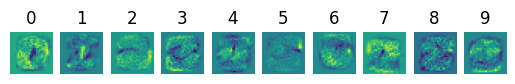

In [ ]:
# We can visualise the learnt weights (one for each class) as images by reshapeing into 28x28 grids

w_cpu = w.cpu().clone()
print(w_cpu.size())

f, axs = plt.subplots(1,number_of_classes)

for k in range(h):
  img = w_cpu[:,k].view(28,28)
  axs[k].imshow(img)
  axs[k].set_title(k)
  axs[k].axis("off")

**###Optional### BONUS MATERIAL** -  Other optimisers and Adam

**###Optinional### Question 5** implement your some of the optimisers form ex1 and see how they perfrom in this setting? What differences do you notice?

In [ ]:
def generate_p(n):
  p_unnorm = np.random.normal(0,1,n)
  p = p_unnorm / np.linalg.norm(p_unnorm)

  return  torch.from_numpy(p)


with torch.no_grad(): # in this exersize we will not use autograd you will have calucated gradent

  # fixing a device to run the codes on
  device = torch.device("cuda:0")

  w = torch.zeros(input_dimension,number_of_classes).to(device)
  m = torch.zeros(input_dimension,number_of_classes).to(device)

  eta = 1e-1
  num_epochs = 10

  for i in range(num_epochs):
    total_loss, total_correct, total_num = 0, 0, 0
    for batch in train_loader:
      #extractign data and labels from batch
      X,y = batch[0].to(device).view(batch[0].size()[0],input_dimension), batch[1].to(device)
      Y = index_to_one_hot(y, classes=10)
      # ----------------------------
      # Optimisation -  Your code here
      # Select p first
      print(X.shape)
      print(w.shape)
      p = generate_p(w.shape).to(device)

      # Workout which of the 3 points gives the min loss
      points = [(w - eta *p), w, (w + eta *p)]
      points_loss = [CE_loss(X,y, point.float()) for point in points]
      min_points_loss = np.min(points_loss)
      theta = points[points_loss.index(min_points_loss)]
      # ----------------------------
      # track loss and accuracy after every step
      loss_train = CE_loss(X, Y, w)
      correct, acc = accuracy(X.mm(w), y)
      total_correct += correct
      total_loss += loss_train*X.size()[0]
      total_num += X.size()[0]

    # ----------------------------
    # After each epoch track metrics
    opt_train_losses.append(float(total_loss/total_num))
    opt_train_acc.append(float(total_correct/total_num * 100))
    val_loss, val_acc = test(w, valid_loader)
    opt_val_losses.append(val_loss)
    opt_val_acc.append(val_acc)
    print('train loss: {:.2e} | train acc: {:.2f} | eta: {:.2f}'.format(float(total_loss/total_num), float(total_correct/total_num * 100), eta))
    print('val loss: {:.2e} | val acc: {:.2f}'.format(val_loss, val_acc))
    print('-'*50)
    # ----------------------------
    # Adjust the learning rate
    eta *= 0.9

torch.Size([64, 784])
torch.Size([784, 10])


RuntimeError: ignored

**Adam** The Adam optimiser is an adeptive gradient method that uses exponial moving averages of previous gradients to estimates a good step size for each parameter. Thus it avoids the need for a learning rate schedule.

remember $\mathbf{m}$, $\mathbf{v}$ and $\mathbf{w}$ are vectors.

\begin{align*}
  \hat{\mathbf{m}_k} &= \frac{\mathbf{m}_k}{1-\beta_1^t},\hspace{0.1cm} \mathbf{m}_k \leftarrow \beta_1 \mathbf{m}_{k-1} + (1-\beta_1)\nabla \ell_{z_t}(\mathbf{w}_t) \\
  \hat{\mathbf{v}}_k &= \frac{\mathbf{v}_k}{1-\beta_2^t},\hspace{0.1cm} \mathbf{v}_k \leftarrow \beta_2 \mathbf{v}_{k-1} + (1-\beta_2)\nabla \ell_{z_t}(\mathbf{w}_t)^2 \\
  \mathbf{w}_{k+1} &\leftarrow \mathbf{w}_{k} - \frac{\eta}{\sqrt{\hat{\mathbf{v}}_k}+\epsilon} \hat{\mathbf{m}}_k \\
\end{align*}




**###Optinional### Question 6** implement the ADAM optimiser with $\beta_1 = 0.9$,$\beta_2 = 0.999$, $\eta=0.001$ and run MNIST data set.

In [ ]:
with torch.no_grad(): # in this exersize we will not use autograd you will have calucated gradent

  # fixing a device to run the codes on
  device = torch.device("cuda:0")

  w = torch.zeros(input_dimension,number_of_classes).to(device)
  m = torch.zeros(input_dimension,number_of_classes).to(device)
  v = torch.zeros(input_dimension, number_of_classes).to(device)

  eta = 1e-3
  beta_1 = 0.9
  beta_2 = 0.999
  num_epochs = 10
  eps = 1e-8

  for i in range(num_epochs):
    total_loss, total_correct, total_num = 0, 0, 0
    for batch in train_loader:
      #extractign data and labels from batch
      X,y = batch[0].to(device).view(batch[0].size()[0],input_dimension), batch[1].to(device)
      Y = index_to_one_hot(y, classes=10)
      # ----------------------------
      # Optimisation -  Your code here

      m = beta_1 * m + (1 - beta_1) * grad_func(X, Y, w)
      v = beta_2 * v + (1 - beta_2) * grad_func(X, Y, w)**2
      m_hat = m / (1 - beta_1**(i+1))
      v_hat = v / (1 - beta_2**(i+1))
      w -= eta * m_hat / (torch.sqrt(v_hat) + eps)


      # ----------------------------
      # track loss and accuracy after every step
      loss_train = CE_loss(X, Y, w)
      correct, acc = accuracy(X.mm(w), y)
      total_correct += correct
      total_loss += loss_train*X.size()[0]
      total_num += X.size()[0]

    # ----------------------------
    # After each epoch track metrics
    adam_train_losses.append(float(total_loss/total_num))
    adam_train_acc.append(float(total_correct/total_num * 100))
    val_loss, val_acc = test(w, valid_loader)
    adam_val_losses.append(val_loss)
    adam_val_acc.append(val_acc)
    print('train loss: {:.2e} | train acc: {:.2f} | eta: {:.2f}'.format(float(total_loss/total_num), float(total_correct/total_num * 100), eta))
    print('val loss: {:.2e} | val acc: {:.2f}'.format(val_loss, val_acc))
    print('-'*50)

train loss: 5.40e-01 | train acc: 86.96 | eta: 0.00
val loss: 3.96e-01 | val acc: 89.42
--------------------------------------------------
train loss: 3.73e-01 | train acc: 90.05 | eta: 0.00
val loss: 3.59e-01 | val acc: 90.14
--------------------------------------------------
train loss: 3.48e-01 | train acc: 90.61 | eta: 0.00
val loss: 3.42e-01 | val acc: 90.47
--------------------------------------------------
train loss: 3.33e-01 | train acc: 90.92 | eta: 0.00
val loss: 3.32e-01 | val acc: 90.72
--------------------------------------------------
train loss: 3.24e-01 | train acc: 91.14 | eta: 0.00
val loss: 3.24e-01 | val acc: 90.88
--------------------------------------------------
train loss: 3.16e-01 | train acc: 91.34 | eta: 0.00
val loss: 3.18e-01 | val acc: 91.00
--------------------------------------------------
train loss: 3.11e-01 | train acc: 91.47 | eta: 0.00
val loss: 3.13e-01 | val acc: 91.10
--------------------------------------------------
train loss: 3.06e-01 | trai

# Nadam (Adam with Nestarov momentum)

By changing the first moving average to a Nesterov accelerated momentum. One computation trick can be applied here: instead of updating the parameters to make momentum step and changing back again, we can achieve the same effect by applying the momentum step of time step t + 1 only once, during the update of the previous time step t instead of t + 1.

In [ ]:
with torch.no_grad(): # in this exersize we will not use autograd you will have calucated gradent

  # fixing a device to run the codes on
  device = torch.device("cuda:0")

  w = torch.zeros(input_dimension,number_of_classes).to(device)
  m = torch.zeros(input_dimension,number_of_classes).to(device)
  v = torch.zeros(input_dimension, number_of_classes).to(device)

  eta = 1e-3
  beta_1 = 0.9
  beta_2 = 0.999
  num_epochs = 10
  eps = 1e-8

  for i in range(num_epochs):
    total_loss, total_correct, total_num = 0, 0, 0
    for batch in train_loader:
      #extractign data and labels from batch
      X,y = batch[0].to(device).view(batch[0].size()[0],input_dimension), batch[1].to(device)
      Y = index_to_one_hot(y, classes=10)
      # ----------------------------
      # Optimisation -  Your code here

      g = grad_func(X, Y, w)
      m = beta_1 * m + (1 - beta_1) * g
      v = beta_2 * v + (1 - beta_2) * g**2


      m_hat = m / (1 - beta_1**(i+1)) + (1 - beta_1) * g / (1 - beta_1**(i+1))


      v_hat = v / (1 - beta_2**(i+1))
      w -= eta * m_hat / (torch.sqrt(v_hat) + eps)


      # ----------------------------
      # track loss and accuracy after every step
      loss_train = CE_loss(X, Y, w)
      correct, acc = accuracy(X.mm(w), y)
      total_correct += correct
      total_loss += loss_train*X.size()[0]
      total_num += X.size()[0]

    # ----------------------------
    # After each epoch track metrics
    adam_train_losses.append(float(total_loss/total_num))
    adam_train_acc.append(float(total_correct/total_num * 100))
    val_loss, val_acc = test(w, valid_loader)
    adam_val_losses.append(val_loss)
    adam_val_acc.append(val_acc)
    print('train loss: {:.2e} | train acc: {:.2f} | eta: {:.2f}'.format(float(total_loss/total_num), float(total_correct/total_num * 100), eta))
    print('val loss: {:.2e} | val acc: {:.2f}'.format(val_loss, val_acc))
    print('-'*50)

train loss: 5.14e-01 | train acc: 87.67 | eta: 0.00
val loss: 3.86e-01 | val acc: 89.62
--------------------------------------------------
train loss: 3.63e-01 | train acc: 90.32 | eta: 0.00
val loss: 3.51e-01 | val acc: 90.29
--------------------------------------------------
train loss: 3.39e-01 | train acc: 90.84 | eta: 0.00
val loss: 3.36e-01 | val acc: 90.51
--------------------------------------------------
train loss: 3.26e-01 | train acc: 91.13 | eta: 0.00
val loss: 3.26e-01 | val acc: 90.93
--------------------------------------------------
train loss: 3.17e-01 | train acc: 91.34 | eta: 0.00
val loss: 3.18e-01 | val acc: 91.06
--------------------------------------------------
train loss: 3.10e-01 | train acc: 91.51 | eta: 0.00
val loss: 3.14e-01 | val acc: 91.17
--------------------------------------------------
train loss: 3.05e-01 | train acc: 91.61 | eta: 0.00
val loss: 3.09e-01 | val acc: 91.21
--------------------------------------------------
train loss: 3.01e-01 | trai